In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [43]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

In [44]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [45]:
df['Date']=df.index

In [46]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [47]:
df=df.loc[mask]

In [48]:
df=df.loc[mask]

In [49]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [50]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [51]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [52]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [53]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [54]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [55]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 400)          323200    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 400)          961600    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 100)               40100     
                                                           

In [56]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [57]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [58]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
4/4 [==============================] - 13s 1s/step - loss: 3233.3274 - mae: 36.6579 - mse: 3233.3274 - val_loss: 754.3167 - val_mae: 21.2384 - val_mse: 754.3167
Epoch 2/100
4/4 [==============================] - 3s 697ms/step - loss: 3208.7607 - mae: 36.8209 - mse: 3208.7607 - val_loss: 741.8215 - val_mae: 21.1713 - val_mse: 741.8215
Epoch 3/100
4/4 [==============================] - 3s 682ms/step - loss: 3197.2808 - mae: 36.8466 - mse: 3197.2808 - val_loss: 746.4084 - val_mae: 21.1667 - val_mse: 746.4084
Epoch 4/100
4/4 [==============================] - 3s 734ms/step - loss: 3191.5437 - mae: 36.8095 - mse: 3191.5437 - val_loss: 747.3182 - val_mae: 21.1677 - val_mse: 747.3182
Epoch 5/100
4/4 [==============================] - 3s 665ms/step - loss: 3182.0154 - mae: 36.6803 - mse: 3182.0154 - val_loss: 751.0414 - val_mae: 21.1738 - val_mse: 751.0414
Epoch 6/100
4/4 [==============================] - 3s 711ms/step - loss: 3169.9087 - mae: 36.5434 - mse: 3169.9087 - val_loss: 

Bi-directional GRU

In [59]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 400)          243600    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 50, 400)          722400    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 100)               40100     
                                                           

In [60]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [61]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [62]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
4/4 [==============================] - 12s 1s/step - loss: 3252.0984 - mae: 36.6186 - mse: 3252.0984 - val_loss: 751.7831 - val_mae: 21.2155 - val_mse: 751.7831
Epoch 2/100
4/4 [==============================] - 2s 592ms/step - loss: 3213.1624 - mae: 37.0609 - mse: 3213.1624 - val_loss: 735.5361 - val_mae: 21.1535 - val_mse: 735.5361
Epoch 3/100
4/4 [==============================] - 2s 619ms/step - loss: 3196.8052 - mae: 37.0209 - mse: 3196.8052 - val_loss: 742.0913 - val_mae: 21.1251 - val_mse: 742.0913
Epoch 4/100
4/4 [==============================] - 2s 567ms/step - loss: 3184.6294 - mae: 36.7246 - mse: 3184.6294 - val_loss: 745.8004 - val_mae: 21.1220 - val_mse: 745.8004
Epoch 5/100
4/4 [==============================] - 2s 598ms/step - loss: 3177.0417 - mae: 36.4836 - mse: 3177.0417 - val_loss: 751.9120 - val_mae: 21.1530 - val_mse: 751.9120
Epoch 6/100
4/4 [==============================] - 2s 559ms/step - loss: 3163.0271 - mae: 36.2694 - mse: 3163.0271 - val_loss: 

Predictions

In [63]:
train_idx[:T+1]=False

In [64]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [65]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [66]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [67]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [68]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [69]:
last_train=train.iloc[-1]['Prev Close']

In [70]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [71]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

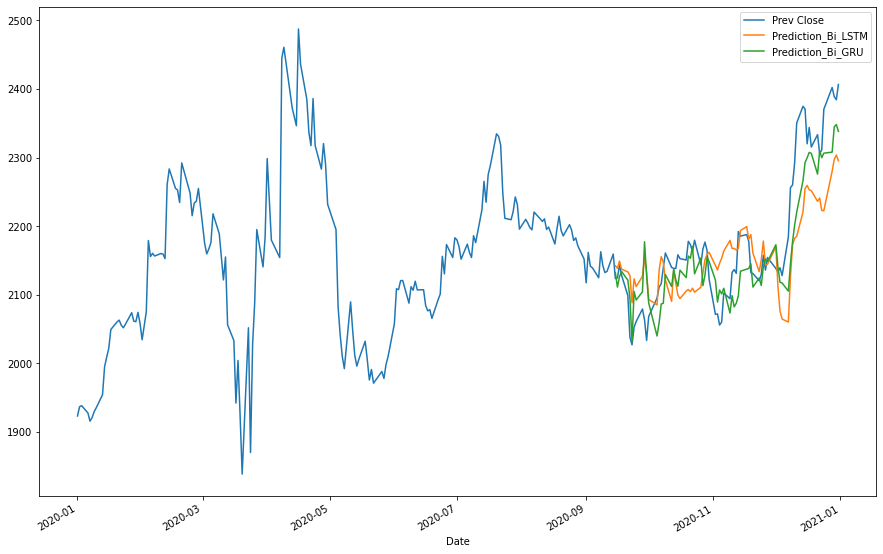

In [72]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

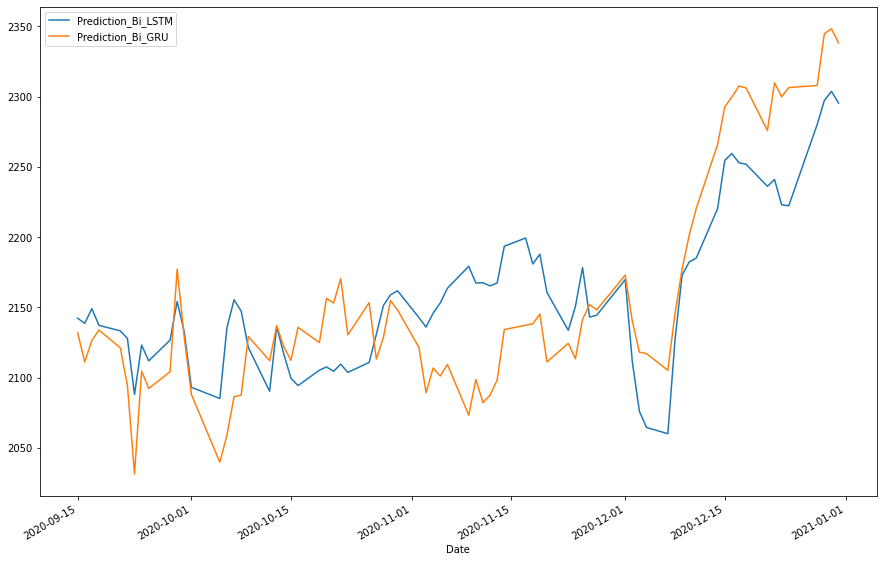

In [73]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [74]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [75]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

68.78059519893917


In [76]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

56.50485550944009


In [77]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.5236759583398141

In [78]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [79]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

49.23896478599549


In [80]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

38.78935722891488


In [81]:
r2_score(test['Prev Close'],pred_bi_gru)

0.75588837024799